--------
## Step 1: Pseudocode
[In this pdf](https://github.com/neurodata/checklists/blob/master/Tutorials/kmeans-alg.pdf) with [this latex source](https://www.overleaf.com/read/vnqnkphxpzyf).

--------
## Step 2: Simulations & Details of Their Parameters

##### Success
- 1-D vector of 20 observations, two clusters with
  - 10 of them class 0 with values between 0 and 1, and
  - 10 of them class 1 with values between 4 and 5

##### Failure
- 1-D vector of 20 observations, two clusters with
  - 10 of them class 0 with values between 0 and 1, and
  - 10 of them class 1 with values between -5 and 5

-------
## Step 3: Choose Visualization
We will use a scatter plot in which the clusters are shown as the colour of the points belonging to them, with a legend identifying cluster ID. We will plot, next to this, the true cluster assignments

-------
## Step 4: Specify Metrics for Evaluating Performance
We will use the *truth* function, which returns 1 if values match and 0 if they do not. Because cluster value is arbitrary, we will first sort the clusters to be in ascending order based on their center.

------
## Step 5: Write Code Generating Simulated Data

In [2]:
import numpy as np

# Fix random seed
np.random.seed(123456789)

In [3]:
def simulate_1():
    # Initialize observations
    A_1 = np.random.random(20)
    A_1[10:] += 4

    # Initialize labels
    y_1 = np.repeat(0, 20)
    y_1[10:] += 1
    return (A_1, y_1)

A_1, y_1 = simulate_1()
# print "Simulation 1"
# print "   A     Y"
# print "\n".join(["%2.1e  %d"%item for item in zip(A_1, y_1,)])

In [10]:
def simulate_2():
    # Initialize observations
    A_2 = np.append(np.random.random(10)*10-5, np.random.random(10))

    # Initialize labels
    y_2 = np.repeat(0, 20)
    y_2[10:] += 1

    return (A_2, y_2)

A_2, y_2 = simulate_2()
# print "Simulation 2"
# print "   A     Y"
# print "\n".join(["%2.1e  %d"%item for item in zip(A_2, y_2,)])

----------
## Step 7: Plot Simulated Data

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

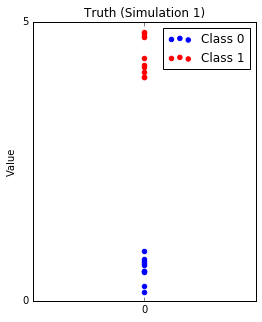

In [13]:
plt.figure(figsize=(4, 5))
plt.scatter(np.zeros(sum(y_1==0)), A_1[y_1==0], color='blue')
plt.scatter(np.zeros(sum(y_1==1)), A_1[y_1==1], color='red')
plt.title('Truth (Simulation 1)')
plt.ylabel('Value')
plt.yticks([0, 5])
plt.xticks([0])
plt.ylim([0, 5])
plt.legend(['Class 0', 'Class 1'], bbox_to_anchor=(1, 1))

plt.show()

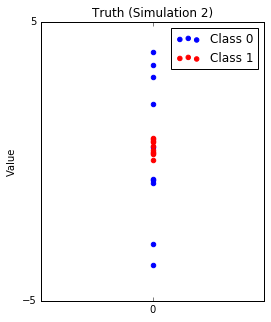

In [15]:
plt.figure(figsize=(4, 5))
plt.scatter(np.zeros(sum(y_2==0)), A_2[y_2==0], color='blue')
plt.scatter(np.zeros(sum(y_2==1)), A_2[y_2==1], color='red')
plt.title('Truth (Simulation 2)')
plt.ylabel('Value')
plt.yticks([-5, 5])
plt.xticks([0])
plt.ylim([-5, 5])
plt.legend(['Class 0', 'Class 1'], bbox_to_anchor=(1, 1))

plt.show()

---------
## Step 8: Write Algorithm Code

In [16]:
from sklearn.cluster import KMeans

def my_kmeans_1d(A, k):
    # Cluster data
    classif = KMeans(n_clusters=k, random_state=0).fit(A.reshape(-1,1))

    # Parse cluster assignments and prepare them to be compared to truth
    c = classif.labels_
    cent = classif.cluster_centers_
    a = sorted(range(len(cent)), key=lambda k: cent[k])

    # Super janky, toggles labels if permutated in 2-class case
    c = np.array([0 if a[0] == item else a[0] for item in c])
    return c

------
## Step 9: Write Qualitative Evaluation Code

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def evaluate_qual(A, y, c):
    plt.figure(figsize=(4, 5))
    plt.subplot(121)
    plt.scatter(np.zeros(sum(y==0)), A[y==0], color='blue')
    plt.scatter(np.zeros(sum(y==1)), A[y==1], color='red')
    plt.title('Truth')
    plt.ylabel('Value')
    plt.yticks([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.xticks([0])
    plt.ylim([np.floor(np.min(A)), np.ceil(np.max(A))])

    plt.subplot(122)
    plt.scatter(np.zeros(sum(c==0)), A[c==0], color='blue')
    plt.scatter(np.zeros(sum(c==1)), A[c==1], color='red')
    plt.legend(['Class 0', 'Class 1'], bbox_to_anchor=(2, 1))
    plt.title('Predicted')
    plt.yticks([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.xticks([0])
    plt.ylim([np.floor(np.min(A)), np.ceil(np.max(A))])

    plt.show()

-------
## Step 10: Write Quantitative Evaluation Code

In [19]:
def truth(y, c):
    return 1.0*sum(y == c)/len(y)

-------
## Step 11: Run + Quantitatively Evaluate Simulation

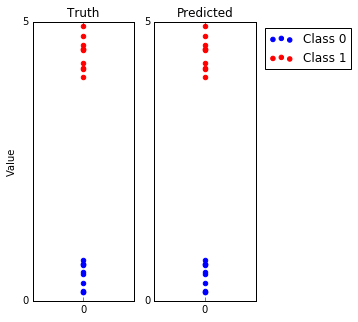

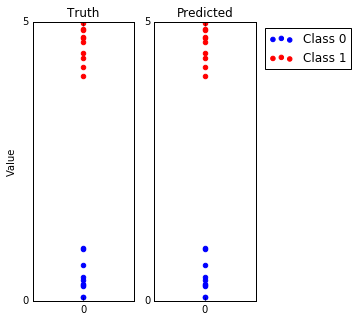

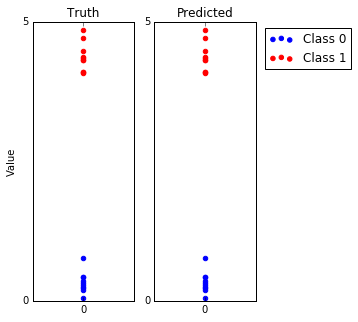

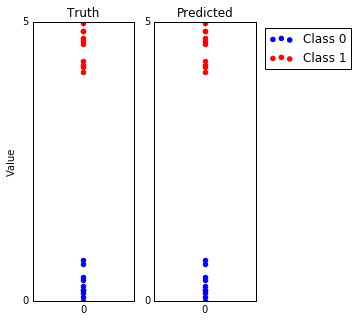

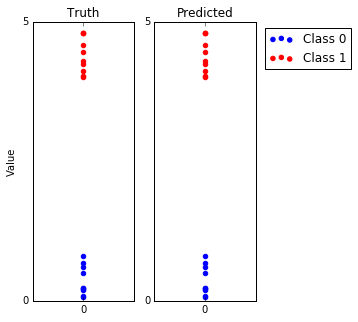

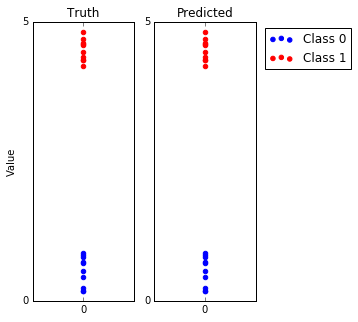

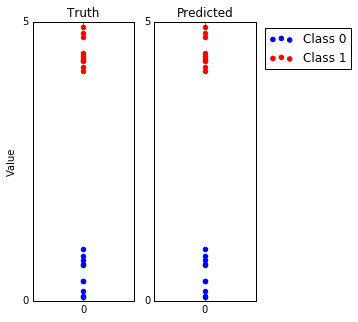

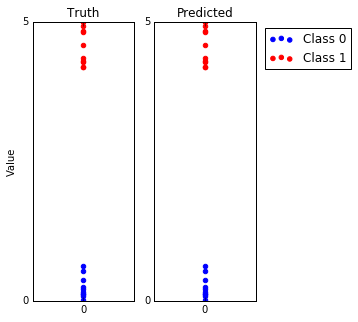

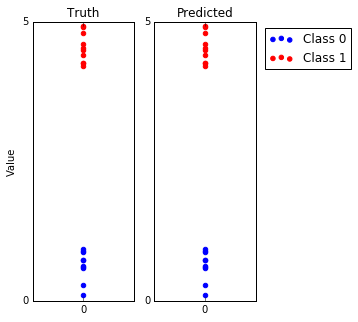

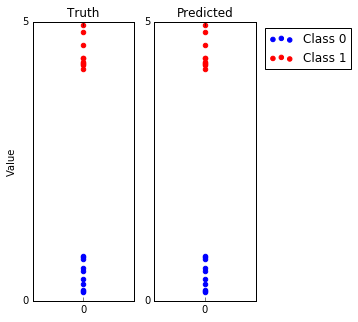

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [20]:
performance_1 = []
for idx in range(10):
    # Cluster data
    A_1, y_1 = simulate_1()
    c_1 = my_kmeans_1d(A_1, 2)
    evaluate_qual(A_1, y_1, c_1)
    performance_1 += [truth(y_1, c_1)]
    # print "   A     Y  C"
    # print "\n".join(["%2.1e  %d  %d"%item for item in zip(A_1, y_1, c_1)])
print performance_1

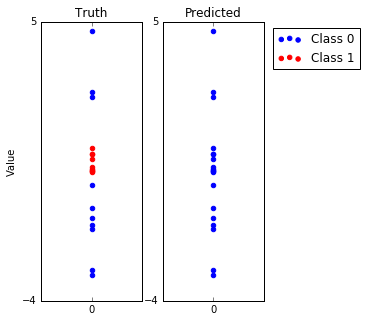

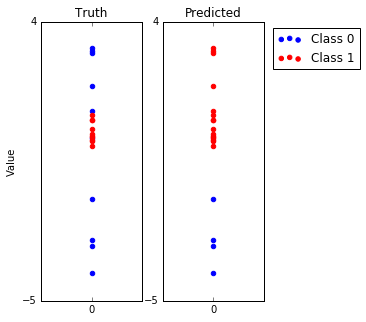

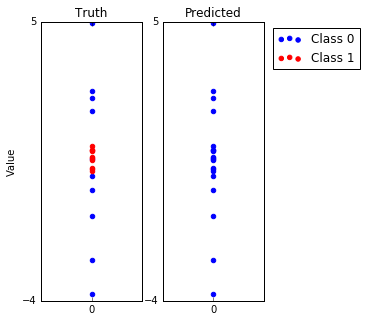

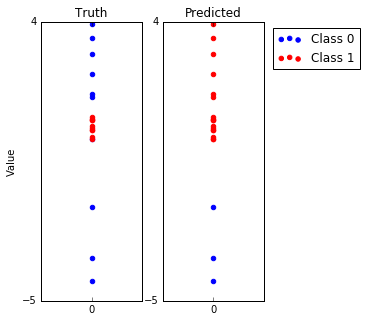

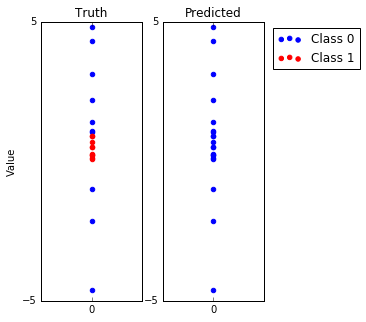

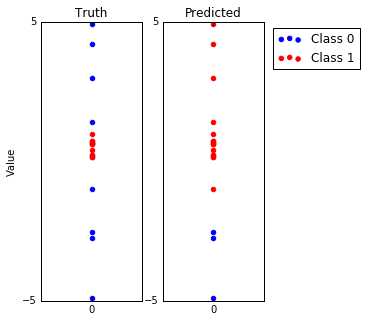

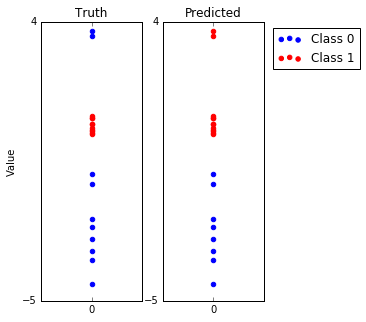

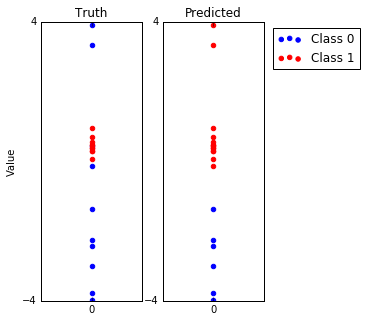

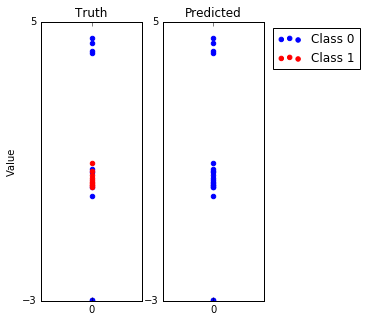

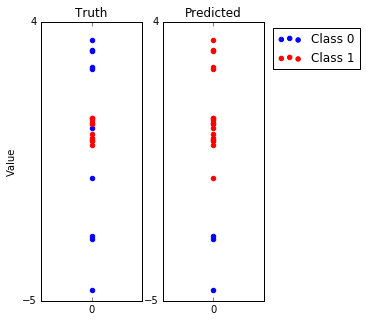

[0.5, 0.7, 0.5, 0.65, 0.5, 0.65, 0.9, 0.8, 0.5, 0.65]


In [21]:
performance_2 = []
for idx in range(10):
    # Cluster data
    A_2, y_2 = simulate_2()
    c_2 = my_kmeans_1d(A_2, 2)
    evaluate_qual(A_2, y_2, c_2)
    performance_2 += [truth(y_2, c_2)]

    # print "   A     Y  C"
    # print "\n".join(["%2.1e  %d  %d"%item for item in zip(A_2, y_2, c_2)])
print performance_2

-------
## Step 12: Qualitatively Evaluate
My algorithm performed as expected in both simulations. In the first case, we have perfect accuracy. In the second, we are getting approximately chance each time.

-------
## Step 13: Simulation Assessment
The algorithm performed as I anticipated on the simulated data, so it appears as though my understanding was good.